In [1]:
import json
import sys
import gc
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')

import numpy       as np
import pandas      as pd
import hipy.pltext as pltext
import awkward     as ak
import matplotlib.pyplot as plt

from wcte.brbtools import sort_run_files, get_part_files, select_good_parts, create_df_from_file
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

pltext.style()

In [2]:
def get_files_from_part(part_file, run_files):
    """
    Input a part_file number and the run_files list created with sort_run_files.
    Extracts all the card_id, channel_id, charge and time information from the hits.
    Returns the arrays for the variables for the part_file.
    """
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    file_hit_times       = tree["hit_pmt_times"].array()
    file_event_number    = tree["event_number"].array()

    return file_hit_card_ids, file_hit_channel_ids, file_hit_charges, file_hit_times, file_event_number

In [3]:
run        = 1626
run_files  = sort_run_files(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
part_files = get_part_files(run_files)
good_parts = select_good_parts(part_files, run_files)

Selecting Good Parts: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


In [4]:
with open('/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger/mmc_map_R1609.json') as f:
    mcc_map = json.load(f)

d = {}
for k,v in zip(mcc_map.keys(), mcc_map.values()):
    card, channel = [int(i) for i in str(int(k)/100).split(".")]
    d[(card, channel)] = v

mcc_map = d

In [14]:
def read_uproot_file(file_path, evt_offset):
    tree = uproot.open(file_path + ":WCTEReadoutWindows")
    
    # Read the variables
    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_times       = tree["hit_pmt_times"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    
    # Get the event number from indices
    nevents = len(file_hit_card_ids)
    evts    = np.arange(nevents)
    nhits   = [len(file_hit_card_ids[ievt]) for ievt in evts]
    file_event_number = np.repeat(evts, nhits)
    
    # # Número de hits por evento
    # n_hits_per_event = ak.num(file_hit_card_ids)
    
    # # Repetir cada número de evento según la cantidad de hits
    # file_event_number = np.repeat(event_number, n_hits_per_event)
    file_event_number = file_event_number + evt_offset
    
    # Flatten all variables
    flat_card_ids = ak.flatten(file_hit_card_ids)
    flat_chan_ids = ak.flatten(file_hit_channel_ids)
    flat_times    = ak.flatten(file_hit_times)
    flat_charges  = ak.flatten(file_hit_charges)

    # corrected_times = np.array([time + (event//512)*(2**35) + ((event%512 == 511) & (time < 2**34))*(2**35) for time, event in tqdm(zip(flat_times, file_event_number), total=len(flat_times))])
    
    return flat_card_ids, flat_chan_ids, file_event_number, flat_times, flat_charges, np.max(file_event_number)

In [15]:
flat_card_ids, flat_chan_ids, file_event_number, flat_times, flat_charges, max_evt = read_uproot_file(run_files[0], 0)

In [ ]:
len(flat_card_ids)26914538

26914538

In [ ]:
evt_offset  = 0
max_card    = 118
max_chan    = 19
run_cards   = None
run_chans   = None
run_charges = None
run_events  = None
run_times   = None

for part in tqdm(good_parts[:2], total=len(good_parts)):
    # print("# 0. Read Part File")
    flat_card_ids, flat_chan_ids, file_event_number, flat_times, flat_charges, max_evt = read_uproot_file(run_files[part], evt_offset)
    evt_offset = max_evt + 1

    # print("# 1. Create a quick lookup table (filled with 0s by default)")
    lookup = np.zeros((max_card + 1, max_chan + 1))

    # print("# 2. Fill the table with the actual map values")
    for (card, chan), shift in mcc_map.items():
        lookup[card, chan] = shift

    # print("# 3. Obtain every correction with vectorized access")
    corrections = lookup[flat_card_ids, flat_chan_ids]

    # print("# 4. Correct the time with mcc constants")
    mcc_corrected_times = flat_times + corrections

    # print("# 5. Correct the time with event number")
    # corrected_times = np.array([time + (event//512)*(2**35) + ((event%512 == 511) & (time < 2**34))*(2**35) for time, event in 
    #                             tqdm(zip(mcc_corrected_times, file_event_number), total=len(mcc_corrected_times))])

    # print("# 6. Concatenate all the info from the run")
    if run_events is None:
        run_events  = file_event_number
        run_times   = mcc_corrected_times
        run_cards   = flat_card_ids
        run_chans   = flat_chan_ids
        run_charges = flat_charges
    else:
        run_events  = ak.concatenate([run_events, file_event_number])
        run_times   = ak.concatenate([run_times, mcc_corrected_times])
        run_cards   = ak.concatenate([run_cards, flat_card_ids])
        run_chans   = ak.concatenate([run_chans, flat_chan_ids])
        run_charges = ak.concatenate([run_charges, flat_charges])

  0%|          | 0/9 [00:49<?, ?it/s]


KeyboardInterrupt: 

In [9]:
corrected_times = np.array([time + (event//512)*(2**35) + ((event%512 == 511) & (time < 2**34))*(2**35) for time, event in tqdm(zip(run_times, run_events), total=len(run_times))])

  3%|▎         | 11714009/370185879 [00:57<29:32, 202244.53it/s]


KeyboardInterrupt: 

In [23]:
subset_event = run_events[::10000]
subset_times = run_times[::10000]
subset_charges = run_charges[::10000]

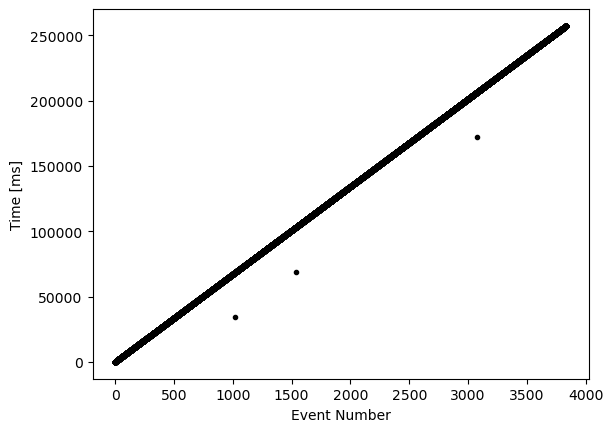

In [24]:
plt.scatter(subset_event, subset_times/1e6, marker=".");
plt.ylabel("Time [ms]");
plt.xlabel("Event Number");

# Hit Rate Of Each mPMT Consistent Over Time

In [25]:
cards = np.unique(run_cards)

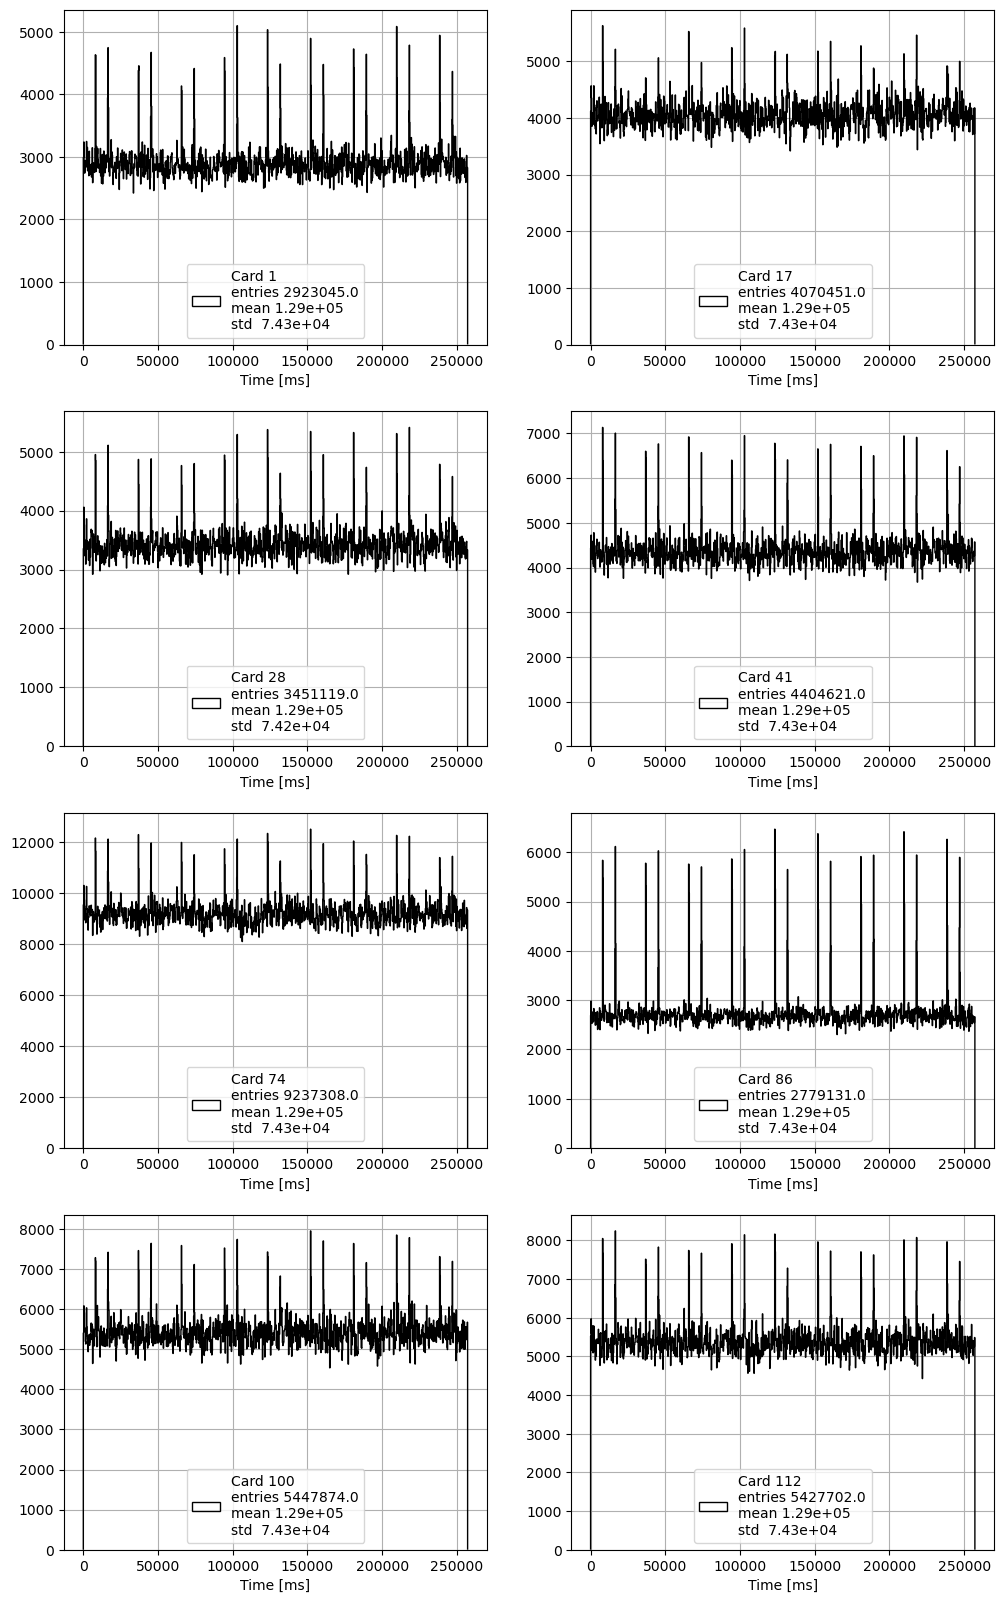

In [26]:
subplot = pltext.canvas(8)

for i, card in enumerate(cards[::11]):
    mask = (run_cards == card)
    card_hit_times = run_times[mask]

    subplot(i+1)
    pltext.hist(card_hit_times/1e6, 1000, xylabels=("Time [ms]"), label=f"Card {card}", formate='.2e');


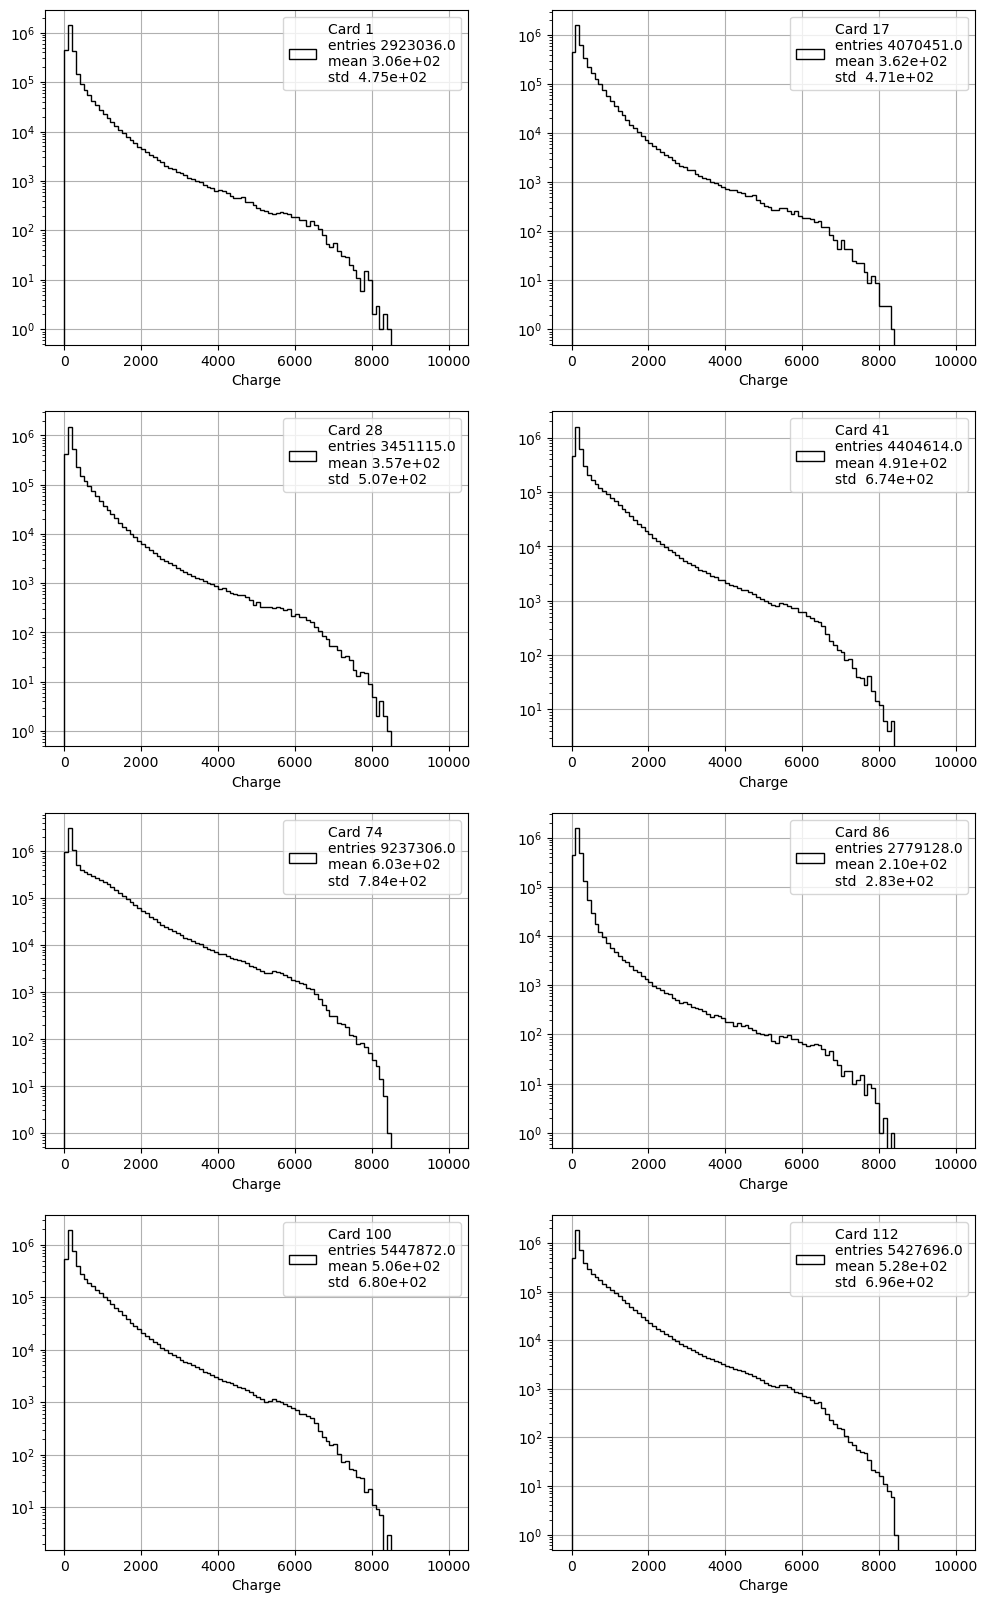

In [13]:
subplot = pltext.canvas(8)

for i, card in enumerate(cards[::11]):
    mask = (run_cards == card)
    card_hit_charges = run_charges[mask]

    subplot(i+1)
    pltext.hist(card_hit_charges, 100, xylabels=("Charge"), range=(0, 10000), ylog=True, label=f"Card {card}", formate='.2e');

In [61]:
events, nhits = np.unique(run_events, return_counts=True)

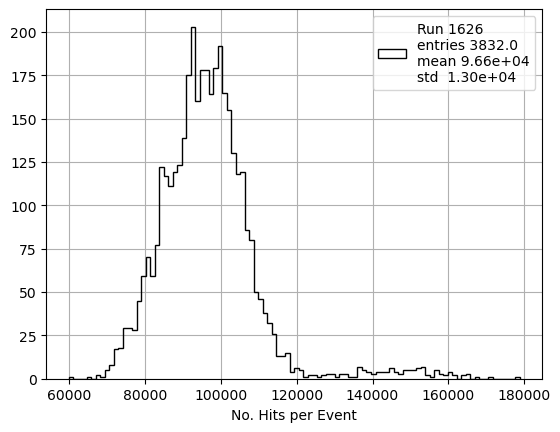

In [69]:
pltext.hist(nhits, 100, ylog=False, xylabels="No. Hits per Event", formate=".2e", label=f"Run {run}");

In [76]:
# Obtener índices únicos y asignaciones inversas
unique_events, inverse_indices = np.unique(run_events, return_inverse=True)

# Sumar los tiempos por grupo
sums = np.bincount(inverse_indices, weights=run_times)

# Contar elementos por grupo
counts = np.bincount(inverse_indices)

# Media por grupo
means = sums / counts


: 

In [ ]:
max_card = 118
max_chan = 19
evt_offset = 0

run_events  = None
run_times   = None
run_cards   = None
run_chans   = None
run_charges = None

for part in tqdm(good_parts, total=len(good_parts)):
    df_part = create_df_from_file(get_files_from_part(good_parts[part], run_files))

    corrected_times = np.array([time + (event//512)*(2**35) + ((event%512 == 511) & (time < 2**34))*(2**35) for time, event in tqdm(zip(df_part.time, df_part.evt + evt_offset), total=len(df_part.time), leave=False)])

    lookup = np.zeros((max_card + 1, max_chan + 1))
    for (card, chan), shift in mcc_map.items():
        lookup[card, chan] = shift
    corrections = lookup[df_part.card, df_part.channel]

    corrected_times = corrected_times + corrections

    if run_events is None:
        run_events  = df_part.evt.values + evt_offset
        run_times   = corrected_times
        run_cards   = df_part.card
        run_chans   = df_part.channel
        run_charges = df_part.charge
    else:
        run_events  = ak.concatenate([run_events, df_part.evt.values + evt_offset])
        run_times   = ak.concatenate([run_times, corrected_times])
        run_cards   = ak.concatenate([run_cards, df_part.card])
        run_chans   = ak.concatenate([run_chans, df_part.channel])
        run_charges = ak.concatenate([run_charges, df_part.charge])

    evt_offset = df_part.evt.max() + 1

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/26914538 [00:00<?, ?it/s]

  0%|          | 0/43149124 [00:00<?, ?it/s]

  0%|          | 0/43062126 [00:00<?, ?it/s]

  0%|          | 0/42981602 [00:00<?, ?it/s]

  0%|          | 0/43964243 [00:00<?, ?it/s]

  0%|          | 0/43651662 [00:00<?, ?it/s]

  0%|          | 0/43781367 [00:00<?, ?it/s]

  0%|          | 0/46381678 [00:00<?, ?it/s]

  0%|          | 0/36299539 [00:00<?, ?it/s]

In [8]:
max_card = 118
max_chan = 19
evt_offset = 0

builder_evt    = ak.ArrayBuilder()
builder_time   = ak.ArrayBuilder()
builder_card   = ak.ArrayBuilder()
builder_chan   = ak.ArrayBuilder()
builder_charge = ak.ArrayBuilder()

for part in tqdm(good_parts, total=len(good_parts)):
    df_part = create_df_from_file(get_files_from_part(good_parts[part], run_files))

    events = df_part.evt.values + evt_offset
    cards  = df_part.card.values
    chans  = df_part.channel.values
    charges = df_part.charge.values

    corrected_times = np.array([
        time + (event // 512) * (2**35) + ((event % 512 == 511) & (time < 2**34)) * (2**35)
        for time, event in tqdm(zip(df_part.time, df_part.evt + evt_offset), total=len(df_part.time), leave=False)
    ])

    lookup = np.zeros((max_card + 1, max_chan + 1))
    for (card, chan), shift in mcc_map.items():
        lookup[card, chan] = shift
    corrections = lookup[df_part.card, df_part.channel]

    corrected_times = corrected_times + corrections

    builder_evt.extend(events)
    builder_time.extend(corrected_times)
    builder_card.extend(cards)
    builder_chan.extend(chans)
    builder_charge.extend(charges)

    evt_offset = df_part.evt.max() + 1

run_events  = builder_evt.snapshot()
run_times   = builder_time.snapshot()
run_cards   = builder_card.snapshot()
run_chans   = builder_chan.snapshot()
run_charges = builder_charge.snapshot()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/26914538 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
tree = uproot.open(run_files[good_parts[0]] + ":WCTEReadoutWindows")
    
# Read the variables
file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
file_hit_times       = tree["hit_pmt_times"].array()
file_hit_charges     = tree["hit_pmt_charges"].array()
event_number         = tree["event_number"].array()

# # # Número de hits por evento
# n_hits_per_event = ak.num(file_hit_card_ids)

# # # Repetir cada número de evento según la cantidad de hits
# file_event_number = np.repeat(event_number, n_hits_per_event)
file_event_number = ak.broadcast_arrays(event_number, file_hit_card_ids)[0]

In [51]:
array = tree.arrays()
file_hit_card_ids, file_hit_channel_ids, file_hit_times, file_hit_charges, event_number = array.hit_mpmt_card_ids, array.hit_pmt_channel_ids, array.hit_pmt_times, array.hit_pmt_charges, array.event_number
file_event_number = ak.broadcast_arrays(event_number, file_hit_card_ids)[0]